# Faster R-CNN

Trying to finetune Faster R-CNN from pytorch.

In [2]:
import os
import data.utils
import torch
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from PIL import Image
from dataclasses import dataclass
from typing import Tuple, List, Iterable

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

### Dataset

In [ ]:
!python ./data/generator.py

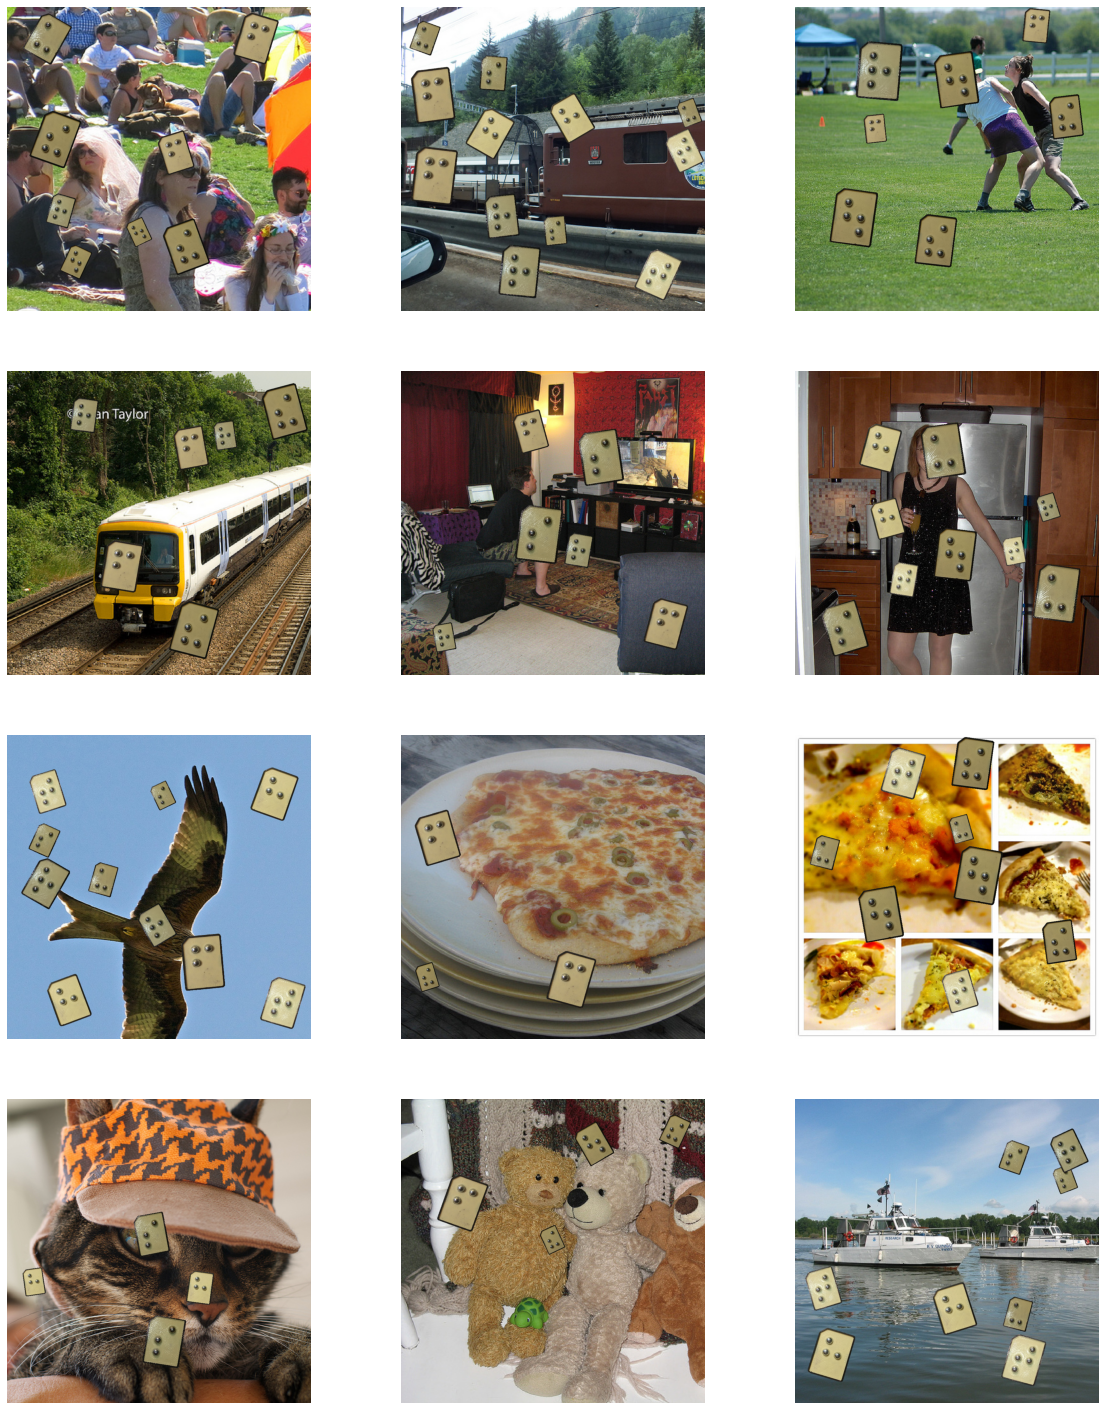

In [14]:
@dataclass
class Label:
    x: int
    y: int
    w: int
    h: int
    c: str
    
    
Labels = List[Label]

class TilesDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.filenames = [filename for filename in os.listdir(folder)
                          if os.path.isfile(os.path.join(folder, filename)) and filename.endswith('.png')]
        
    def __len__(self) -> int:
        return len(self.filenames)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Labels]:
        filename = self.filenames[index]
        path = os.path.join(self.folder, filename)
        
        image = Image.open(path)
        image = self.transform(image) if self.transform is not None else image
        image = torch.from_numpy(np.array(image))
        
        item_name, _ = filename.split('.')
        labels = []
        with open(os.path.join(self.folder, f'{item_name}.txt')) as f:
            for line in f:
                if not line:
                    break
                *ints, c = line.split()
                labels.append(Label(
                    *[int(val) for val in ints], c=c
                ))
        
        return image, labels


def visualize_samples(dataset: Dataset, indices: Iterable[int]) -> None:
    indices = list(indices)
    plt.figure(figsize=(20, len(indices) * 20))
    for i, index in enumerate(indices, 1):
        image, _ = dataset[index]
        plt.subplot(len(indices) * 3, 3, i)
        plt.imshow(image)
        plt.grid(False)
        plt.axis('off')
        

train_folder = os.path.join('..', 'data', 'dataset')
orig_dataset = TilesDataset(train_folder)

visualize_samples(
    orig_dataset, 
    np.random.choice(np.arange(len(orig_dataset)), 12)
)

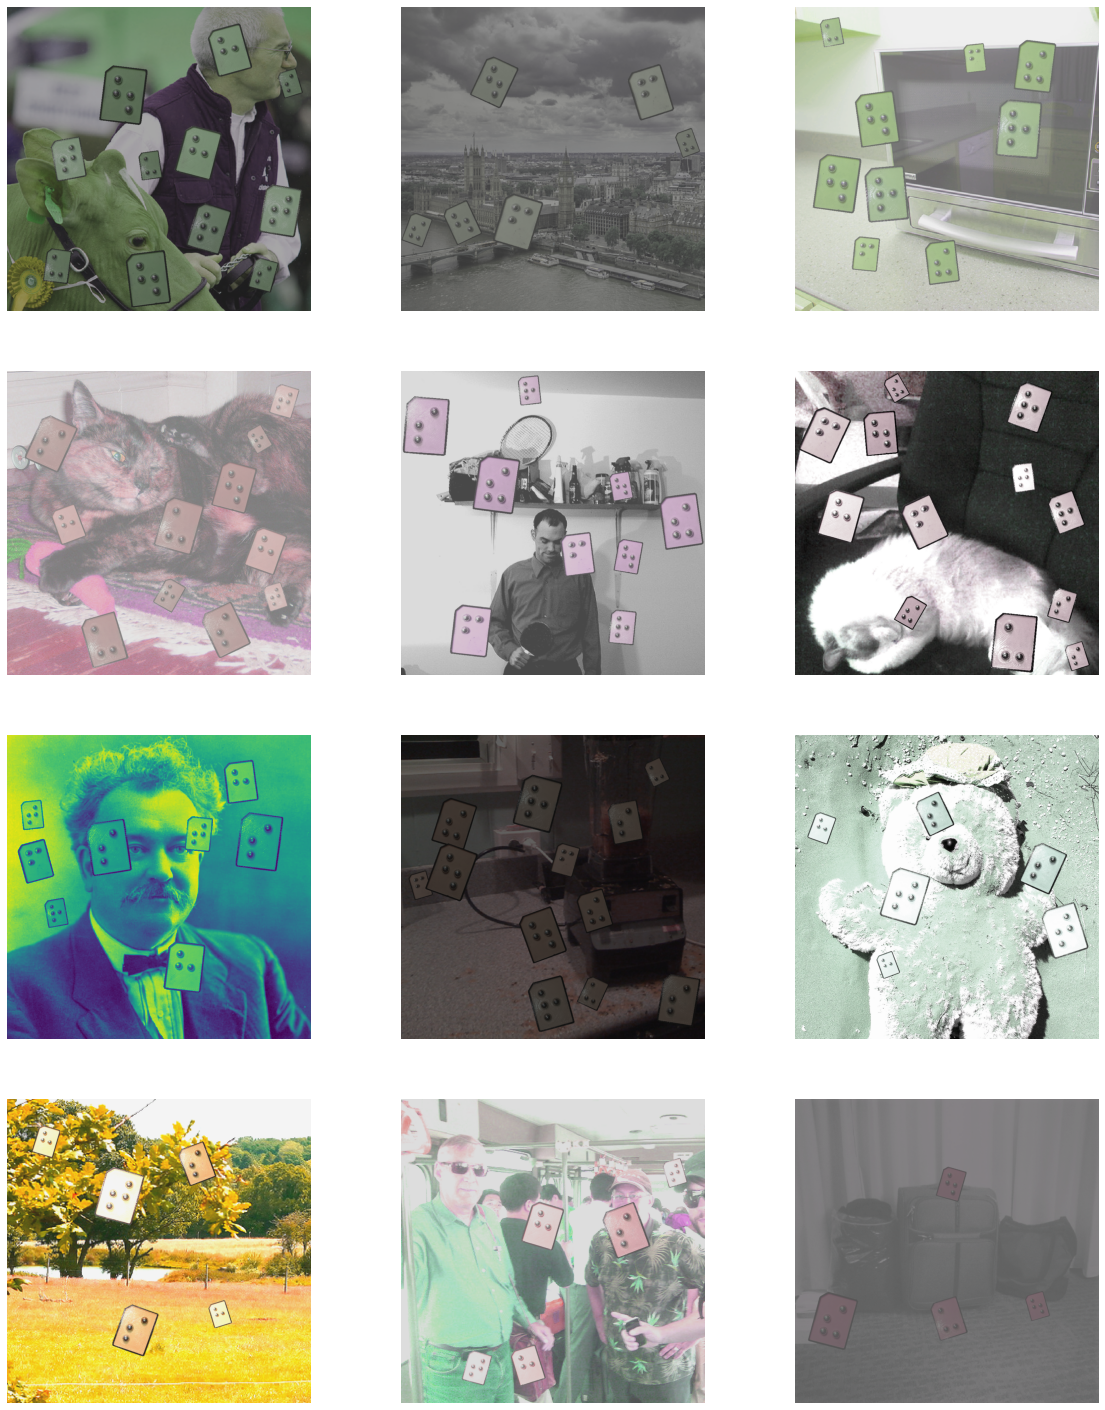

In [25]:
# Define transforms
transform = transforms.Compose([    
    transforms.ColorJitter(brightness=0.6, contrast=0.8, saturation=0.8, hue=0.3),
])

dataset = TilesDataset(train_folder, transform)
visualize_samples(
    dataset, 
    np.random.choice(np.arange(len(dataset)), 12)
)


transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.6, contrast=0.8, saturation=0.8, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])       
])


batch_size = 64

train_dataset = TilesDataset(train_folder, transform)
train_indices = list(range(len(train_dataset)))
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler
)

In [ ]:
# TODO fit to object detection

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    
    n_correct_samples = 0.0
    n_samples = 0.0
    for x, y, _ in loader:
        x = x.to(device)
        y = y.to(device)
        
        prediction = model(x)
        
        indices = torch.argmax(prediction, dim=1)
        n_correct_samples += torch.sum(indices == y)
        n_samples += len(x)
    
    return n_correct_samples / n_samples

